# Mask Model Color

## Dependencies

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

# Import the dependencies.
# OpenCV
import cv2

# TensorFlow and tf.keras
# https://www.tensorflow.org/api_docs/python/tf/keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow Libraries Matter for Speed!!!
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14182112031558914083
]


## Data Loading

In [2]:
# Processed folder houses the already seperated image files
# Images are separated into two categories "without_mask" & "with_mask"
# Grab the location of the processed folder
train_data_path = "../data/processed/train"

# grab the two folder groups and make them to categories
categories = os.listdir(train_data_path)
labels = [i for i in range(len(categories))]

# Initialize an empty dictionary for labels
label_dict = dict(zip(categories, labels))

print(f"Printing the labels'dict' {label_dict}")
print(f"Printing the categories'list' {categories}")
print(f"Printing the labels as digits {labels}")


Printing the labels'dict' {'without_mask': 0, 'with_mask': 1}
Printing the categories'list' ['without_mask', 'with_mask']
Printing the labels as digits [0, 1]


In [3]:
# Processed folder houses the already seperated image files
# Images are sperated into two categories "without_mask" & "with_mask"
# Grab the location of the processed folder
test_data_path = "../data/processed/test"

# grab the two folder groups and make them to categories
test_categories = os.listdir(test_data_path)
test_labels = [i for i in range(len(test_categories))]

# Initialize an empty dictionary for labels
test_label_dict = dict(zip(test_categories, test_labels))

print(f"Printing the labels'dict' {test_label_dict}")
print(f"Printing the categories'list' {test_categories}")
print(f"Printing the labels as digits {test_labels}")


Printing the labels'dict' {'without_mask': 0, 'with_mask': 1}
Printing the categories'list' ['without_mask', 'with_mask']
Printing the labels as digits [0, 1]


## Data Preprocessing

In [4]:
# Normalizing all images to the same size 300x300
img_size = 100
# List
data = []
target = []

# Looping through the processed folder grabing each image
# processing that image through cv2 to gray scale and demension
for category in categories:
    folder_path = os.path.join(train_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        try:
            # Coverting the image into gray scale
            # gray = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
            # Resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            resized = cv2.resize(img, (img_size, img_size))
            # Appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            # If any exception raised, the exception will be printed here. And pass to the next image
            print("Exception:", e)


In [17]:
# Create a numpy array to store data and target
# Normalize data
data = np.array(data) / 255.0

data = np.reshape(data, (data.shape[0], img_size, img_size, 3))
target = np.array(target)
print(type(data))
print(data.shape)
# Use the keras utils tool to create categorical target
new_target = tf.keras.utils.to_categorical(target)


<class 'numpy.ndarray'>
(4464, 100, 100, 3)


In [7]:
# https://numpy.org/doc/stable/reference/generated/numpy.save.html
np.save("numpy/color/data", data)
np.save("numpy/color/target", new_target)


## Building a Model

Using a convolutional neural network (CNN) class of deep learning model.

To build our training and testing datasets, we need to separate two values:

- input values (which are our independent variables commonly referred to as model features or "X" in TensorFlow documentation https://www.tensorflow.org/guide/
- target output (our dependent variable commonly referred to as target or "y" in TensorFlow documentation)

In [8]:
# Loading in the saved numpy arrays in the previous code
data = np.load("numpy/color/data.npy")
target = np.load("numpy/color/target.npy")
print(data.shape[1:])

(100, 100, 3)


In [9]:
# Create the model
model = Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(50, (3, 3), activation="relu", input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(50, (1, 1), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The thrid convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(100, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The fourth convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(200, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to stack the output convolutions from the fourth convolution layer
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

# Dense layer of 64 neurons
model.add(layers.Dense(64, activation="relu"))
# The Final layer with two outputs for two categories
model.add(layers.Dense(2, activation="softmax"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 50)        1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 50)        2550      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 100)       45100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 100)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 200)         1

To enhance the performance of our classification neural network, we'll use the adam optimizer, which uses a gradient descent approach to ensure that the algorithm will not get stuck on weaker classifying variables and features.

As for the loss function, we'll use categorical_crossentropy, which is  is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories, and the model must decide which one.

Formally, it is designed to quantify the difference between two probability distributions.

https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy

In [10]:
# The process of informing the model how it should learn and train is called compiling the model.

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


## Train the Model

https://www.tensorflow.org/guide/keras/train_and_evaluate/

In [11]:
from sklearn.model_selection import train_test_split

# Use the train_test_split to split the data into training and testing set.
# The data set isnt very large so only using 15% to test.
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.15
)


In [12]:
# To train/fit our Keras model, we'll use the fit method and provide the x training values and y training values, as well as the number of epochs.

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model-checkpoints-color/model-{epoch:03d}",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
)
# Fit the model to the training data
fit_model = model.fit(
    train_data, train_target, epochs=30, callbacks=[checkpoint], validation_split=0.2
)


Epoch 1/30
95/95 [==============================] - 14s 141ms/step - loss: 0.5389 - accuracy: 0.7014 - val_loss: 0.1851 - val_accuracy: 0.9315
INFO:tensorflow:Assets written to: model-checkpoints-color\model-001.model\assets
Epoch 2/30
95/95 [==============================] - 13s 142ms/step - loss: 0.2206 - accuracy: 0.9249 - val_loss: 0.1691 - val_accuracy: 0.9420
INFO:tensorflow:Assets written to: model-checkpoints-color\model-002.model\assets
Epoch 3/30
95/95 [==============================] - 14s 146ms/step - loss: 0.1751 - accuracy: 0.9297 - val_loss: 0.3405 - val_accuracy: 0.8340
Epoch 4/30
95/95 [==============================] - 14s 143ms/step - loss: 0.1741 - accuracy: 0.9298 - val_loss: 0.1762 - val_accuracy: 0.9328
Epoch 5/30
95/95 [==============================] - 14s 144ms/step - loss: 0.1255 - accuracy: 0.9566 - val_loss: 0.1402 - val_accuracy: 0.9565
INFO:tensorflow:Assets written to: model-checkpoints-color\model-005.model\assets
Epoch 6/30
95/95 [=====================

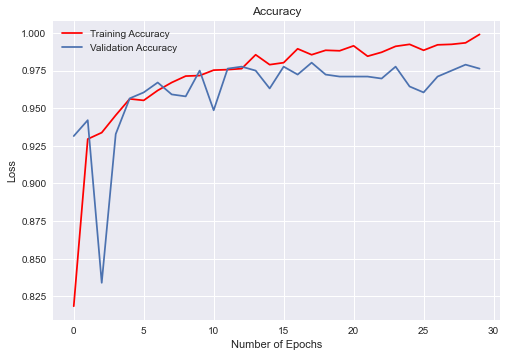

In [13]:
# Another Chart of what
# Defined style for plot
plt.style.use("seaborn")
plt.title("Accuracy")
plt.plot(fit_model.history["accuracy"], "r", label="Training Accuracy")
plt.plot(fit_model.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/accuracy.png")
plt.show()


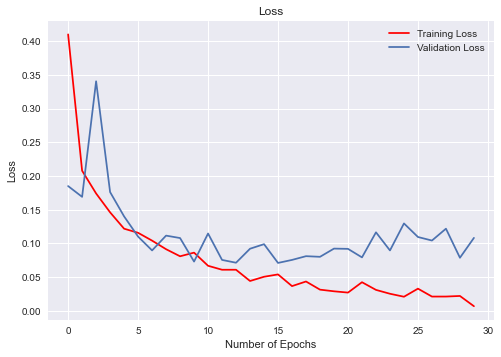

In [14]:
# Chart of What?
# Defined style for plot
plt.style.use("seaborn")
plt.title("Loss")
plt.plot(fit_model.history["loss"], "r", label="Training Loss")
plt.plot(fit_model.history["val_loss"], label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/loss.png")
plt.show()


Overfitting, where the model fits the training data too well. As a result of overfitting, the neural network will not generalize well and won't be able to classify new data correctly.

Double check of over fitting... Usually, when a model performs great on training data but poorly on validation data, we call this condition overfitting... we need more solid data or use Keras Data augmentation 

In [15]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(test_data, test_target,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
print("---------------------------------------------------------------------")
print(model.evaluate(test_data, test_target))


21/21 [==============================] - 1s 37ms/step - loss: 0.0896 - accuracy: 0.9851
[0.08957702666521072, 0.9850746393203735]


In [16]:
# Properly save the model for API use.
model.save("./model-checkpoints-color/model")


INFO:tensorflow:Assets written to: ./model-checkpoints-color/model\assets


As with all machine learning algorithms, neural networks are not perfect and will often underperform using a basic implementation. When a neural network model does not meet performance expectations, it is usually due to one of two causes: inadequate or inappropriate model design for a given dataset, or insufficient or ineffective training data.

In [ ]:
Therefore, the most straightforward means of improving neural network performance is tweaking the model design and parameters.

There are a few means of optimizing a neural network:

- Check out your input dataset.
- Add more neurons to a hidden layer.
- Add additional hidden layers.
- Use a different activation function for the hidden layers.
- Add additional epochs to the training regimen.